<a href="https://colab.research.google.com/github/ErnCharles/ml_opne/blob/main/pytorch_model_deployment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 47.67 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# train and test paths

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [5]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  #setup pretrained model
  effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnet_model = torchvision.models.efficientnet_b2(weights=effnet_weights)

  transforms= effnet_weights.transforms()

  for param in effnet_model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  effnet_model.classifier = torch.nn.Sequential(
      nn.Dropout(p=.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return effnet_model, transforms

In [14]:
effnet_model, effnet_transforms = create_effnetb2_model()

In [7]:
effnet_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnet_model,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

In [15]:
import os
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = effnet_transforms,
    batch_size=32,
    num_workers = os.cpu_count()
)

In [16]:
optimizer = torch.optim.Adam(params=effnet_model.parameters(),lr=0.003)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
from going_modular.going_modular import engine

set_seeds()

effnetb2_model_results = engine.train(
    model=effnet_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8081 | train_acc: 0.6875 | test_loss: 0.3991 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.4360 | train_acc: 0.8792 | test_loss: 0.3024 | test_acc: 0.9563
Epoch: 3 | train_loss: 0.3651 | train_acc: 0.8708 | test_loss: 0.2568 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.2458 | train_acc: 0.9333 | test_loss: 0.2481 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.2404 | train_acc: 0.9313 | test_loss: 0.2311 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.3314 | train_acc: 0.9125 | test_loss: 0.2141 | test_acc: 0.9625
Epoch: 7 | train_loss: 0.3023 | train_acc: 0.9062 | test_loss: 0.2246 | test_acc: 0.9290
Epoch: 8 | train_loss: 0.3442 | train_acc: 0.8958 | test_loss: 0.2278 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3257 | train_acc: 0.8729 | test_loss: 0.2102 | test_acc: 0.9250
Epoch: 10 | train_loss: 0.3491 | train_acc: 0.8604 | test_loss: 0.1905 | test_acc: 0.9597


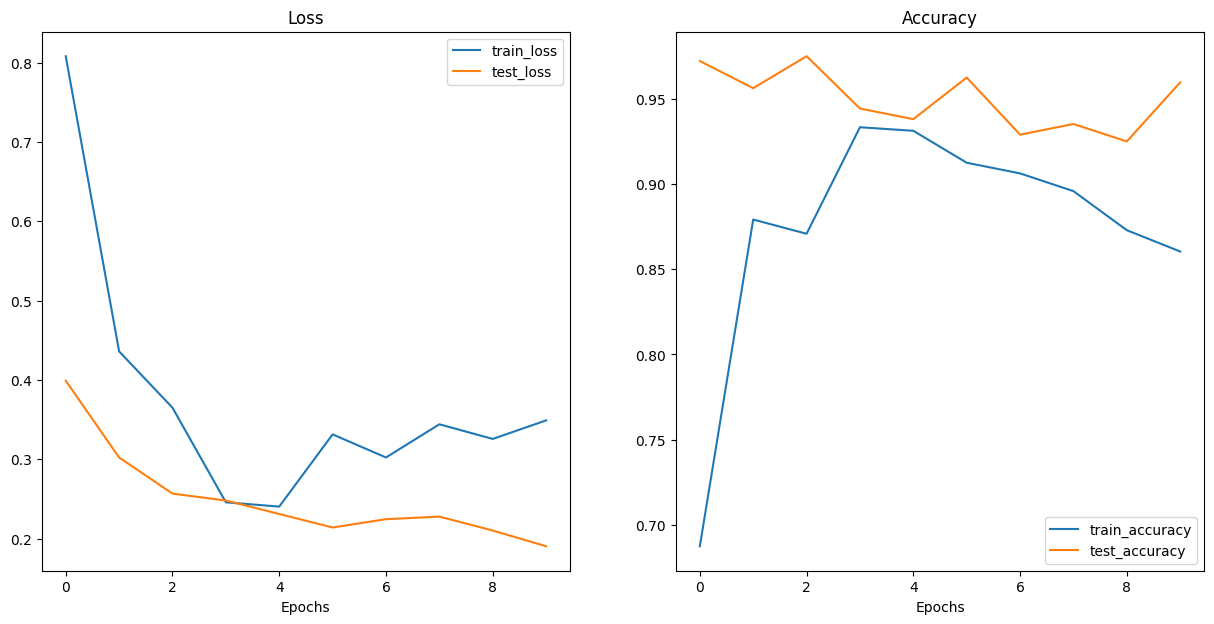

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_model_results)

In [21]:
from going_modular.going_modular import utils

utils.save_model(model=effnet_model,target_dir="models",model_name="effnetb2_model.pth")

[INFO] Saving model to: models/effnetb2_model.pth
